This model is similar to the other all data set, but I also look at emphasis on/off 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from random import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import pydicom


Similar to what we did in our image conversion notebook, we will first make a list of all our PNG images

In [2]:
neg_dir='D:\\tensorflow_datasets\\covid-CT\\negative\\images'
pos_dir='D:\\tensorflow_datasets\\covid-CT\positive\\images'

# Get the list of all files in directory tree at given path
def buildList(directoryPath):
    listOfFiles = list()
    for (dirpath, dirnames, filenames) in os.walk(directoryPath):
        listOfFiles += [os.path.join(dirpath, file) for file in filenames]
    return listOfFiles

In [3]:
positive_files=buildList(pos_dir)
negative_files=buildList(neg_dir)

Now we can verify our data - it should look the same as in our conversion notebook

In [4]:
print('negative file example: ', negative_files[0])
print('positive file example: ', positive_files[0])
print('\n')
print('# of negative results: ', len(negative_files))
print('# of positive results: ', len(positive_files))
print('total images: ', len(negative_files)+len(positive_files))

print('positive:negative ratio: ', len(positive_files)/len(negative_files))

negative file example:  D:\tensorflow_datasets\covid-CT\negative\images\img0.png
positive file example:  D:\tensorflow_datasets\covid-CT\positive\images\img0.png


# of negative results:  21220
# of positive results:  31856
total images:  53076
positive:negative ratio:  1.501225259189444


Now let's read a single DICOM image to test, and output the image array that we will be using. We aren't going to be using the other info attached to the dicom images - we only want the images themselves. We can use pydicom to read the images, and with numpy installed we can convert the pixel array to an ndarray

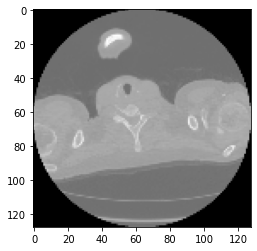

In [5]:
img=cv2.imread(negative_files[0])
plt.imshow(img)


In [6]:
def buildSet(fileList, label):
    i=0
    data_df=[]
    for f in fileList: 
        path = f
        img = cv2.imread(f)
        data_df.append([np.array(img), label, path])
        i+=1
    shuffle(data_df)
    return data_df

Now let's build our sets. This will take a while since we are reading all of the images 1-by-1

For now, we will use a small subset to make sure our code works, then run it again with the whole directory. 

In [7]:
class_info={0: 'COVID-negative', 1:'COVID-positive'}

positive_set = buildSet(positive_files,1)
negative_set = buildSet(negative_files,0)

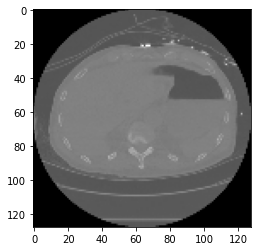

In [8]:
# make sure the images are still accessible - they are stored in a df so we need to acces the 
    #first element of the first array
plt.imshow(positive_set[0][0])

Now we should merge the positive and negative test images, and build our x_train and y_train set. 

In [9]:
xtrain_positives = np.array([i[0] for i in positive_set])
xtrain_negatives = np.array([i[0] for i in negative_set])
X = np.concatenate((xtrain_positives,xtrain_negatives))

ytrain_negatives= np.array([i[1] for i in negative_set])
ytrain_positives= np.array([i[1] for i in positive_set])
y = np.concatenate((ytrain_positives,ytrain_negatives))

In [10]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [11]:
X.shape
#shape should be (nsamples,image_height,image_width,depth)

(53076, 128, 128, 3)

In [12]:
def make_model(input_shape):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(filters=32, kernel_size=2, activation="relu")(inputs)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=64, kernel_size=2, activation="relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=128, kernel_size=2, activation="relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=256, kernel_size=2, activation="relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="2dcnn")
    return model

#use the shape from above here (last 3 values)
model = make_model(input_shape=(128,128,3))
model.summary()

Model: "2dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 127, 127, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 64)        256   

In [13]:
from sklearn.model_selection import train_test_split

val_split = 0.20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_split, stratify=y)

X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))

In [14]:
from sklearn.model_selection import train_test_split

val_split = 0.20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_split, stratify=y)

X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))

In [15]:
y_train.shape

(42460,)

In [16]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=val_split)

train_data = datagen.flow(X, y, subset = 'training')
val_data = datagen.flow(X,y,subset= 'validation')  


In [17]:
train_data

In [18]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "2d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
    
model.fit(train_data, validation_data=val_data, epochs=epochs,callbacks=[checkpoint_cb, early_stopping_cb])

'''model.fit(
    x=x_train,
    y=y_train,
    validation_split=0.10,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)'''


Epoch 1/100
1327/1327 [==============================] - 51s 32ms/step - loss: 0.4340 - acc: 0.7939 - val_loss: 0.2622 - val_acc: 0.8997
Epoch 2/100
1327/1327 [==============================] - 36s 27ms/step - loss: 0.1997 - acc: 0.9247 - val_loss: 0.1379 - val_acc: 0.9512
Epoch 3/100
1327/1327 [==============================] - 36s 27ms/step - loss: 0.0858 - acc: 0.9732 - val_loss: 0.0844 - val_acc: 0.9713
Epoch 4/100
1327/1327 [==============================] - 37s 28ms/step - loss: 0.0460 - acc: 0.9861 - val_loss: 0.0274 - val_acc: 0.9928
Epoch 5/100
1327/1327 [==============================] - 36s 27ms/step - loss: 0.0287 - acc: 0.9919 - val_loss: 0.0222 - val_acc: 0.9945
Epoch 6/100
1327/1327 [==============================] - 36s 27ms/step - loss: 0.0183 - acc: 0.9949 - val_loss: 0.0266 - val_acc: 0.9910
Epoch 7/100
1327/1327 [==============================] - 36s 27ms/step - loss: 0.0153 - acc: 0.9956 - val_loss: 0.0085 - val_acc: 0.9980
Epoch 8/100
1327/1327 [==================

'model.fit(\n    x=x_train,\n    y=y_train,\n    validation_split=0.10,\n    epochs=epochs,\n    shuffle=True,\n    verbose=2,\n    callbacks=[checkpoint_cb, early_stopping_cb],\n)'

0


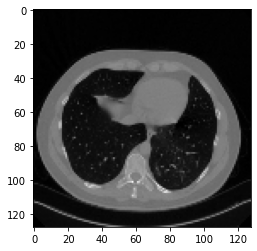

In [19]:
img = X[0]
print(y[0])
plt.imshow(img)

0
0


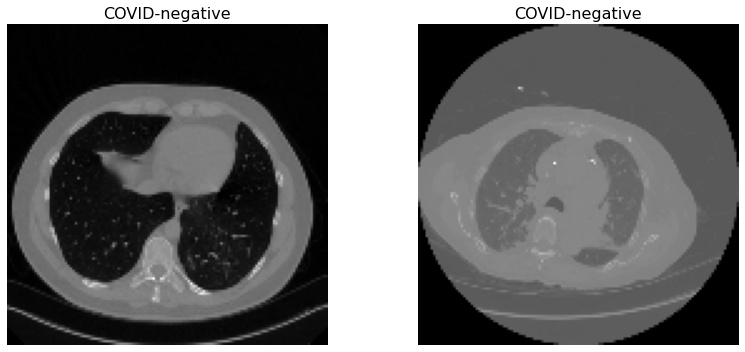

In [20]:
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tensorflow.keras.applications.vgg16 import preprocess_input




img1=X[0]
print(y[0])
img2=X[1]
print(y[1])

images = np.asarray([img1, img2])

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
for i, title in enumerate(images):
    ax[i].set_title(class_info[y[i]], fontsize=16)
    ax[i].imshow(images[i],cmap='gray')
    ax[i].axis('off')
plt.tight_layout()
plt.show()


In [21]:
images.shape

(2, 128, 128, 3)

In [22]:
def decode_prediction(pred):
  # This function thresholds a probability to produce a prediction
    pred = tf.where(pred < 0.5, 0, 1)
    return pred.numpy()

img = X[0]
label = y[0]

pred_raw = model.predict(np.expand_dims(img, axis=0))[0][0]

pred = decode_prediction(pred_raw)
pred_label = class_info[pred]

print('true label: ',label, '\n', 'Prediction: ', pred_label, pred_raw)


true label:  0 
 Prediction:  COVID-negative 2.4588329e-07


In [23]:
from tensorflow.keras.models import Model

def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(
            inputs=[model.inputs],
            outputs=[model.get_layer(layer_name).output,
                model.output])
    
    with tf.GradientTape() as tape:
# cast the image tensor to a float-32 data type, pass the
# image through the gradient model, and grab the loss
# associated with the specific class index
        inputs = tf.cast(img_array, tf.float32)
        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[:, 0]
# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
# the convolution and guided gradients have a batch dimension
# (which we don't need) so let's grab the volume itself and
# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
# as weights, compute the ponderation of the filters with
# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
# return the resulting heatmap to the calling function
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    

    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

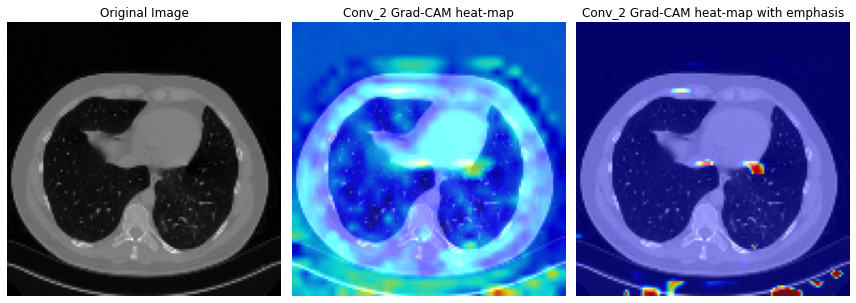

In [48]:
layer_name = 'conv2d_2'
img = X[0]
label = y[0]

grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=False)
grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 3, 1)
plt.imshow(img,)
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 3, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Conv_2 Grad-CAM heat-map')
plt.tight_layout()
ax = plt.subplot(1, 3, 3)
plt.imshow(grad_cam_emphasized)
plt.axis('off')
plt.title('Conv_2 Grad-CAM heat-map with emphasis')
plt.tight_layout()

Here we can see the comparison between the regular superimposed gradCAM and the emphasized version. We can see that the border along the bottom of the image seems to be a feature that is detected - this might be because there are different orientations that the patient is in resulting in different ct images. The model also looks at more of the tissue (white whereas rgay is a cavity), which is good. From further above, we know that this is a covid-negative patient, and it's interesting to see what spots on the body are features in the emphasized version

Let's look at all the layers now.

In [26]:
conv2D_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]
conv2D_layers

['conv2d_3', 'conv2d_2', 'conv2d_1', 'conv2d']

In [27]:
activation_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]
activation_layers

['conv2d_3', 'conv2d_2', 'conv2d_1', 'conv2d']

In [28]:
all_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4]
all_layers

['batch_normalization_3',
 'max_pooling2d_3',
 'conv2d_3',
 'batch_normalization_2',
 'max_pooling2d_2',
 'conv2d_2',
 'batch_normalization_1',
 'max_pooling2d_1',
 'conv2d_1',
 'batch_normalization',
 'max_pooling2d',
 'conv2d']

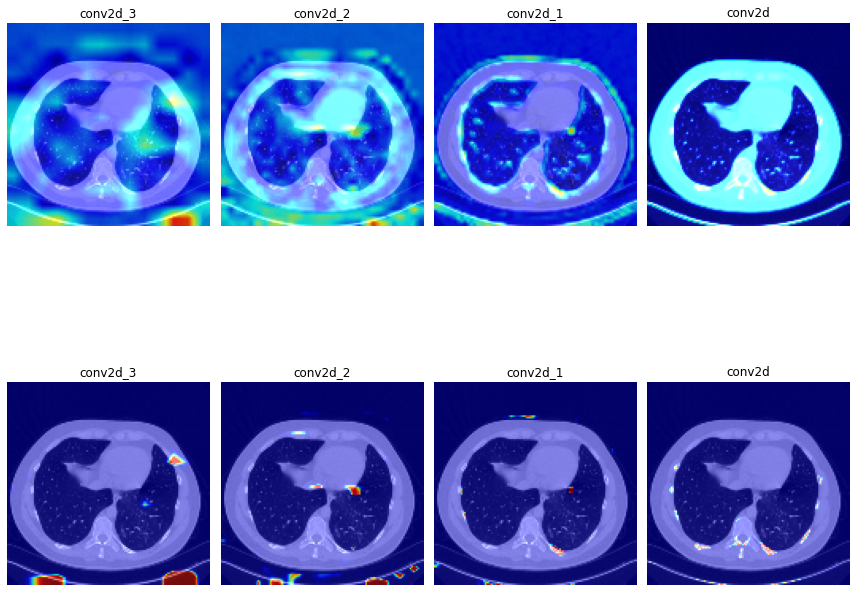

In [67]:
img = X[0]


plt.figure(figsize=(12,12))
for i, layer in enumerate(activation_layers):
    grad_cam = GradCam(model, np.expand_dims(img, axis=0), layer)
    grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=False)
    ax = plt.subplot(2,4, i +1)
    plt.imshow(grad_cam_superimposed)
    plt.title(layer)
    plt.axis("off")
for i, layer in enumerate(activation_layers):
    grad_cam = GradCam(model, np.expand_dims(img, axis=0), layer)
    grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=True)
    ax = plt.subplot(2,4, i +5)
    plt.imshow(grad_cam_emphasized)
    plt.title(layer)
    plt.axis("off")    
plt.tight_layout()


The top row is the regular version, and the bottom is the emphasized version. Again, we can see specific areas of tissue that are being looked at. The spots highlighted in the lungs would be the "correct" features identified in relation to a disease such as COVID that affects the lungs. Additionally, the blob between the lungs is the heart, so we would also want to see features identified here as COVID also affects the heart. 

These are some pretty interesting results! But here I've only included the convolution layers. So, lets actually look at ALL of the layers (that are valid)

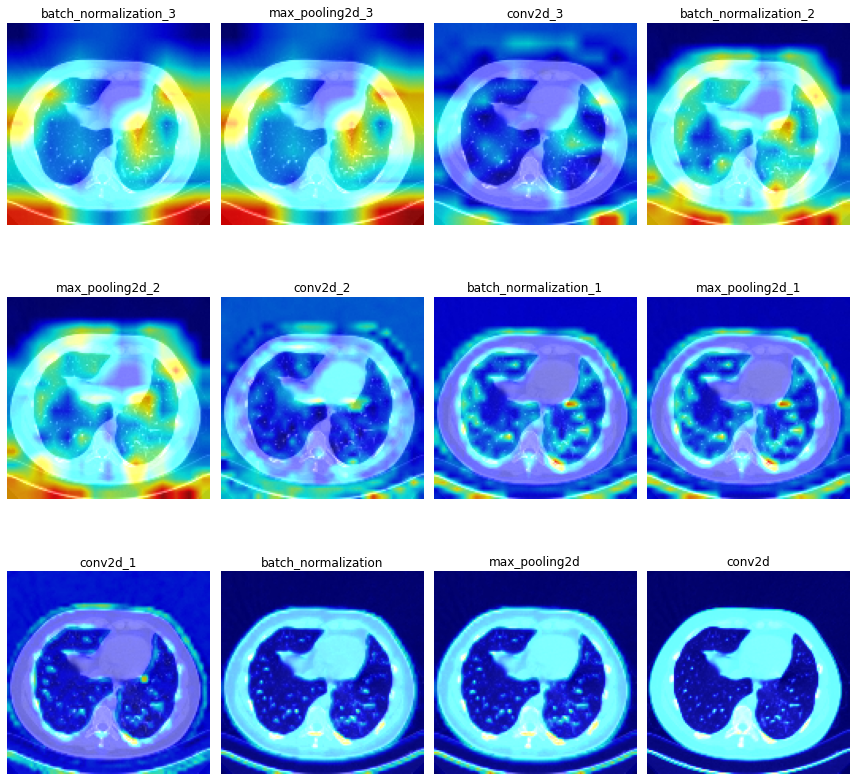

In [30]:
img = X[0]


plt.figure(figsize=(12, 12))
for i, layer in enumerate(all_layers):
    grad_cam = GradCam(model, np.expand_dims(img, axis=0), layer)
    grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=False)
    ax = plt.subplot(3, 4, i +1)
    plt.imshow(grad_cam_emphasized)
    plt.title(layer)
    plt.axis("off")
plt.tight_layout()

superimposed version ^

emphasized version v

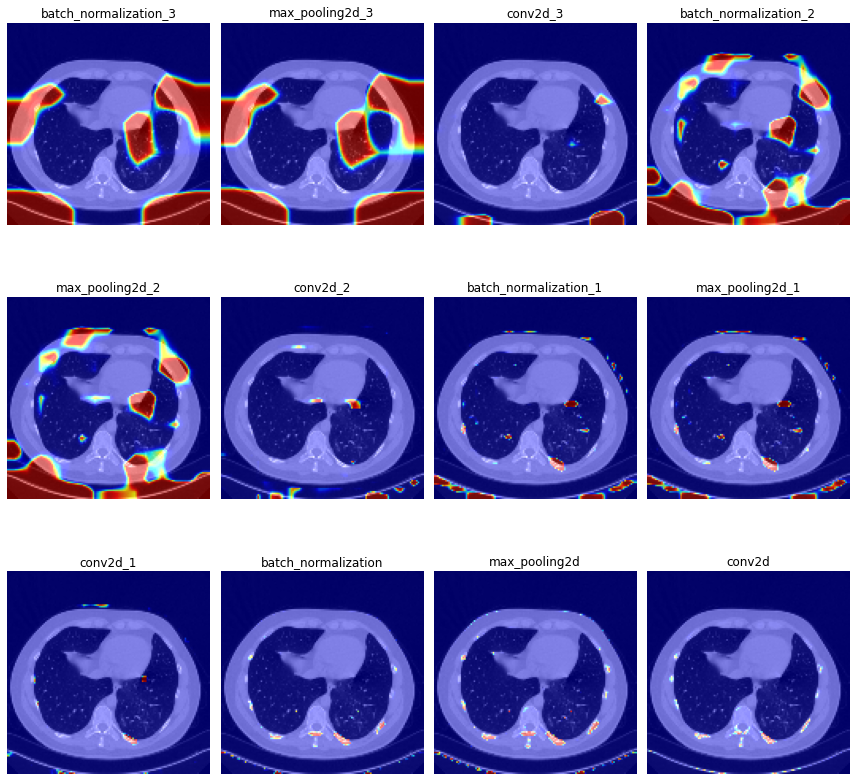

In [52]:
img = X[0]


plt.figure(figsize=(12, 12))
for i, layer in enumerate(all_layers):
    grad_cam = GradCam(model, np.expand_dims(img, axis=0), layer)
    grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=True)
    ax = plt.subplot(3, 4, i +1)
    plt.imshow(grad_cam_emphasized)
    plt.title(layer)
    plt.axis("off")
plt.tight_layout()

These are some interesting results. We can see regions being highlighted in both versions that seem to roughly correspod with what a doctor would look for - the white parts in/around the lungs and the heart and the type of CT scan (position of patient), which is all good. In the first alldata notebook, I discuss some issues with the model, such as the poor train/test split. 


In [33]:
y[201]

1

Lastly, lets create a fused grad-cam for all of the layers combined

In [34]:
'''  
Fuses grad-cam heatmaps from a list of model layers into a single heatmap
and superimposes the heatmap onto an image.

Args:
  layers: list of strings
  model: tf model
  img: (img_width x img_height x 3) numpy array


Returns 
  uint8 numpy array with shape (img_height, img_width, 3)

'''
def fuse_layers(layers, model, img, emphasize=False):
    cams = []
    for layer in layers:
        cam = GradCam(model, np.expand_dims(img, axis=0), layer)
        cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
        cams.append(cam)

    fused = np.mean(cams, axis=0)
    superimposed = superimpose(img, fused, 0.5, emphasize=emphasize)

    return superimposed

Text(0.5, 1.0, 'All layers Grad-CAM heat-map emphasized')

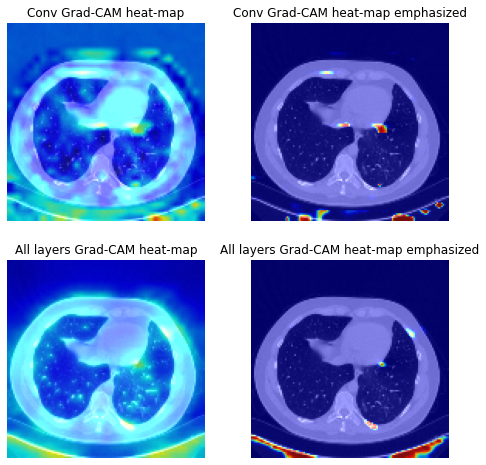

In [63]:
img=X[0]
grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=False)
grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=True)
fused = fuse_layers(all_layers, model, img, False)
fused_emphasized = fuse_layers(all_layers, model, img, True)

plt.figure(figsize=(8, 8))

ax = plt.subplot(2, 2, 1)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Conv Grad-CAM heat-map')

ax = plt.subplot(2, 2, 2)
plt.imshow(grad_cam_emphasized)
plt.axis('off')
plt.title('Conv Grad-CAM heat-map emphasized')

ax = plt.subplot(2, 2, 3)
plt.imshow(fused)
plt.axis('off')
plt.title('All layers Grad-CAM heat-map')

ax = plt.subplot(2, 2, 4)
plt.imshow(fused_emphasized)
plt.axis('off')
plt.title('All layers Grad-CAM heat-map emphasized')



1